In [31]:
import numpy as np
from umap import UMAP
from matplotlib import pyplot as plt
from umap.umap_ import nearest_neighbors
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [32]:
DEP_COL = "_HYPNO-mode"

# Utility functions to load in the data
dataset = np.load("sc-agg-f16.npz")

# Create a reproducible sample of rows from the given set
def generate_sample(size_per, set_name="train_patients", random_state=42):
    # Set up the random state & the row storage
    r = np.random.RandomState(random_state)
    rows = []

    # Loop through each person in the named set and select that number of rows, randomly
    for entry in dataset[set_name]:
        entry_set = dataset[entry]
        to_get = size_per if type(size_per) is int else int(size_per * entry_set.shape[0])
        selection = r.choice(range(entry_set.shape[0]), size=to_get, replace=False)
        rows.extend(entry_set[selection])

    # Return the sample and the labels
    return np.array(rows, dtype=float), dataset["labels"]

# Convert a sample to X and y pairs, with numeric values in the place of NaNs
def to_xy_numeric(sample, labels):
    dep_col_idx = np.where(labels == DEP_COL)[0]
    X = np.delete(sample, dep_col_idx, axis=1)
    y = sample[:, dep_col_idx]
    y[np.isnan(y)] = 6
    return X, y

# Plot the result of a clustering test
def plot_result(X, y):
    dims = X.shape[1]
    if dims == 2:
        plt.scatter(*X.T, c=y, cmap="rainbow", marker=".", alpha=0.7)
        plt.show()
    else:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(*X.T, c=y, cmap="rainbow", marker=".", alpha=0.7)
        plt.show()

In [33]:
X_train, y_train = to_xy_numeric(*generate_sample(1., random_state=1919))
X_valid, y_valid = to_xy_numeric(*generate_sample(0.05, set_name="validate_patients", random_state=456))

In [34]:
# Append the datasets
#X_full = X_train
#y_full = y_train
X_full = np.vstack((X_train, X_valid))
y_full = np.vstack((y_train, -1 * np.ones(shape=y_valid.shape)))

In [35]:
# Normalize
X_full /= np.max(X_full, axis=1).reshape((-1,1))

In [36]:
# Compute nearest neighbors
precomputed_knn = nearest_neighbors(X_full, n_neighbors=90, metric="euclidean", metric_kwds=None, angular=False, random_state=1, verbose=True)

Thu Apr  4 16:54:39 2024 Finding Nearest Neighbors
Thu Apr  4 16:54:39 2024 Building RP forest with 28 trees
Thu Apr  4 16:54:40 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Thu Apr  4 16:55:27 2024 Finished Nearest Neighbor Search


In [37]:
# Construct the model & get the fit
model = UMAP(precomputed_knn=precomputed_knn, n_components=3, init="pca", n_epochs=10, n_neighbors=90, target_weight=0.7, verbose=True)
X_res = model.fit_transform(X_full, y_full)

UMAP(init='pca', n_components=3, n_epochs=10, n_neighbors=90, precomputed_knn=(array([[     0, 152371, 1716, ..., 181801, 150441, 56811],
       [     1, 1019, 1982, ..., 2112, 11167, 129144],
       [     2, 406, 1280, ..., 53506, 150, 4538],
       ...,
       [208876, 188018, 187412, ..., 174982, 26029, 178961],
       [208877, 164197, 188471, ..., 188613, 158946, 160314],
       [208878, 186621, 208634, ..., 127366, 129398, 188143]], dtype=int32), array([[0.        , 0.11020047, 0.11571261, ..., 0.2176712 , 0.21853271,
        0.21878879],
       [0.        , 0.06895816, 0.08067763, ..., 0.1088917 , 0.10890283,
        0.10917269],
       [0.        , 0.05876375, 0.06054728, ..., 0.08124953, 0.0812603 ,
        0.08135305],
       ...,
       [0.        , 0.08852744, 0.08958243, ..., 0.12055813, 0.12057496,
        0.12082166],
       [0.        , 0.08814038, 0.09084027, ..., 0.12820287, 0.12842147,
        0.12865505],
       [0.        , 0.14466716, 0.15354149, ..., 0.22850607, 0

Epochs completed:   0%|            0/10 [00:00]

	completed  0  /  10 epochs
	completed  1  /  10 epochs
	completed  2  /  10 epochs
	completed  3  /  10 epochs
	completed  4  /  10 epochs
	completed  5  /  10 epochs
	completed  6  /  10 epochs
	completed  7  /  10 epochs
	completed  8  /  10 epochs
	completed  9  /  10 epochs
Thu Apr  4 16:55:42 2024 Finished embedding


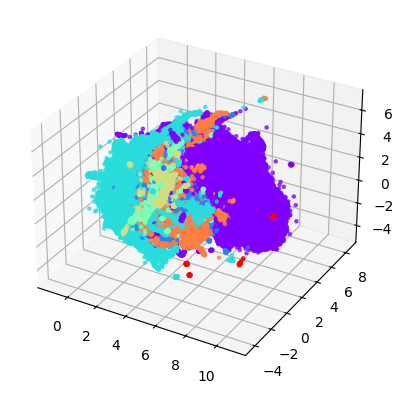

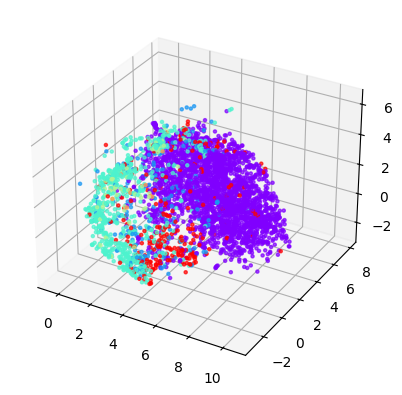

In [38]:

# Make a plot of just the training data
plot_result(X_res[:X_train.shape[0]], y_train)

# Make a plot of just the validation data
plot_result(X_res[X_train.shape[0]:], y_valid)

In [ ]:
model = PCA()
X_res = model.fit_transform(X_full)